## Tutorial 3 - Autoencoder Continued Training

In this example, we will demonstrate how a model that has been pretrained can be continued to train with new data. This is useful when you have a model that has been trained on a large dataset, and you want to fine-tune it to a new dataset. BUT, we demonstrate that this is not always a good idea.

In [2]:
import numpy as np
from tensorflow.keras.datasets import mnist
from tensorflow import keras
from matplotlib import pyplot as plt
import tensorflow as tf
from tensorflow.keras.preprocessing import image
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras import Model, Input
from tensorflow.keras.layers import Dense

from tensorflow.keras.callbacks import EarlyStopping # EarlyStopping during model training
import tensorflow as tf
from tensorflow.keras.preprocessing import image


### Load and normalize our data

In [3]:
# load MNIST data
(train_images, train_labels), (test_images, test_labels) = mnist.load_data()
print(train_images.shape)
print(test_images.shape)

# Flatten the images for a autoencoder input (28x28 is 784 -- therfore, input is 784 neurons)
train_images = np.reshape(train_images, (-1, 784))
test_images = np.reshape(test_images, (-1, 784))
print(train_images.shape)
print(test_images.shape)

# Normalize data - since it's grayscale, we can divide by 255 to get each pixel between 0 and 1
train_images = train_images.astype('float32') / 255
test_images = test_images.astype('float32') / 255

(60000, 28, 28)
(10000, 28, 28)
(60000, 784)
(10000, 784)


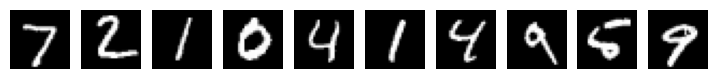

In [4]:
n = 10
plt.figure(figsize=(9, 2))
for i in range(n):
  ax = plt.subplot(1, n, i+1)
  plt.imshow(test_images[i].reshape(28, 28), cmap="gray")
  ax.axis('off')

plt.show()

### Load the pretrained model from tutorial 1

In [5]:
pretrained_model = keras.models.load_model('initially_trained_autoencoder.tf')

### Load the first character of my last name and test the autoencoder on this image

1/1 [==============================] - 0s 289ms/step
(1, 784)


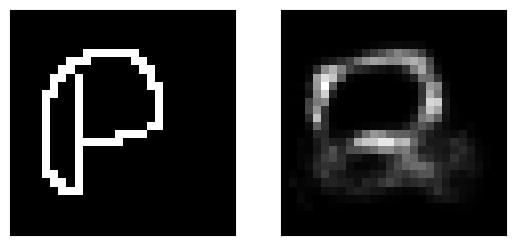

In [6]:
####################################
# load the first charcter
firstchar_image = tf.keras.utils.load_img('firstchar-2.png', target_size=(28, 28), color_mode = "grayscale")

####################################
# predict an image from this sample
firstchar_input_arr = tf.keras.utils.img_to_array(firstchar_image)
firstchar_input_arr = firstchar_input_arr/ 255 # normalize between 0 and 1
firstchar_input_arr = firstchar_input_arr.reshape(784)
firstchar_input_arr = np.array([firstchar_input_arr])  # Convert single image to a batch with one image in it

firstchar_predictions = pretrained_model.predict(firstchar_input_arr)
print(firstchar_predictions.shape)

#####################################
# display the two images side by side
#
plt.subplot(1,2,1)
plt.xticks([])
plt.yticks([])
plt.grid(False)
plt.imshow(firstchar_image, cmap="gray")


plt.subplot(1,2,2)
plt.xticks([])
plt.yticks([])
plt.grid(False)
plt.imshow(firstchar_predictions[0].reshape(28,28), cmap="gray")


plt.show()

### Load the first character of my first name and test the autoencoder on this image

1/1 [==============================] - 0s 78ms/step
(1, 784)


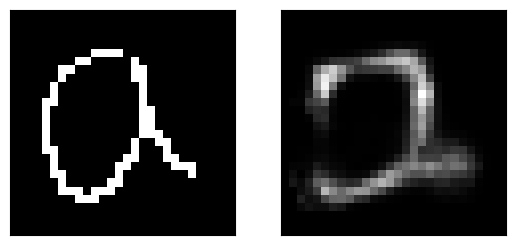

In [7]:
####################################
# loading the last character
lastchar_image = tf.keras.utils.load_img('lastchar-2.png', target_size=(28, 28), color_mode = "grayscale")

####################################
# predict the image from this sample
lastchar_input_arr = tf.keras.utils.img_to_array(lastchar_image)
lastchar_input_arr = lastchar_input_arr/ 255 # normalize between 0 and 1
lastchar_input_arr = lastchar_input_arr.reshape(784)
lastchar_input_arr = np.array([lastchar_input_arr])  # Convert single image to a batch with one image in it

lastchar_predictions = pretrained_model.predict(lastchar_input_arr)
print(lastchar_predictions.shape)

#####################################
# display the two images side by side
#
plt.subplot(1,2,1)
plt.xticks([])
plt.yticks([])
plt.grid(False)
plt.imshow(lastchar_image, cmap="gray")


plt.subplot(1,2,2)
plt.xticks([])
plt.yticks([])
plt.grid(False)
plt.imshow(lastchar_predictions[0].reshape(28,28), cmap="gray")


plt.show()

This autoencoder doesn't do a good job with this new symbol because it was not trained with similar images as my first and last characters.

### Trying to continue training the model on the original 10 digits and with the new symbol mixed in

### I am now combining new images with original 10 digits

In [8]:
num_new = 500 # number of samples of the new image

num_mnist = 5000 # number of samples from the MNIST dataset to use to include in this new dataset
first_input_arr = firstchar_input_arr.reshape(784) # flatten the first character

first_new_images = [first_input_arr for _ in range(num_new)] # create a new dataset of the first character
first_new_image_set = np.vstack((train_images[:num_mnist], first_new_images)) # combine the new images with the MNIST images
np.random.shuffle(first_new_image_set) # shuffling the new dataset to have random set of digits


input_arr = lastchar_input_arr.reshape(784) # flatten the last character
#np.random.shuffle(train_images) # shuffle the MNIST dataset

new_images = [input_arr for _ in range(num_new)] # create a new dataset of the last characters
new_image_set = np.vstack((first_new_image_set[:num_mnist], new_images)) # combine the new images with the MNIST images
np.random.shuffle(new_image_set) # shuffling the new dataset to have random set of digits

new_images_train, new_images_test = np.split(new_image_set, [int(len(new_image_set)*.8)]) # split into training and test sets

### Displaying the combined data

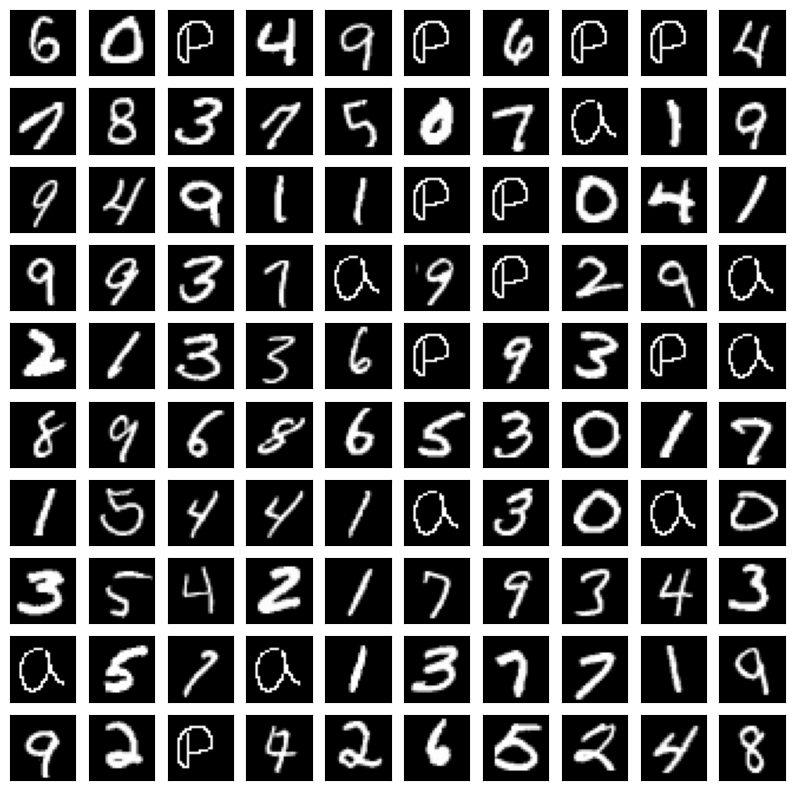

In [9]:
images = []
for i in range(100):
    images.append(new_image_set[i].reshape(28,28))
rows = 10
cols = 10
plt.figure(figsize=(10,10))
for i in range(rows*cols):
    plt.subplot(rows,cols,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(images[i],cmap='gray')

plt.show()

### training the new dataset

### Implementing Autoencoder

In [12]:
input_dim = 28*28
latent_vec_len = 20 # this is the 'bottleneck' of the autoencoder

# Define the autoencoder architecture
# build the encoder
autoencoder = Sequential()
autoencoder.add(Input(shape=(input_dim,)))
autoencoder.add(Dense(500, activation='relu'))
autoencoder.add(Dense(300, activation='relu'))
autoencoder.add(Dense(100, activation='relu'))

# the bottleneck layer
autoencoder.add(Dense(latent_vec_len, activation='relu'))

# the decoder layer
autoencoder.add(Dense(100, activation='relu'))
autoencoder.add(Dense(300, activation='relu'))
autoencoder.add(Dense(500, activation='relu'))
autoencoder.add(Dense(input_dim, activation='sigmoid'))

# Compile the autoencoder model
autoencoder.compile(loss='binary_crossentropy', optimizer='adam')

# Get summary
autoencoder.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_8 (Dense)             (None, 500)               392500    
                                                                 
 dense_9 (Dense)             (None, 300)               150300    
                                                                 
 dense_10 (Dense)            (None, 100)               30100     
                                                                 
 dense_11 (Dense)            (None, 20)                2020      
                                                                 
 dense_12 (Dense)            (None, 100)               2100      
                                                                 
 dense_13 (Dense)            (None, 300)               30300     
                                                                 
 dense_14 (Dense)            (None, 500)              

In [13]:


# Train the autoencoder with MNIST data
early_stop = EarlyStopping(monitor='loss', patience=3, verbose=1)
history = autoencoder.fit(
    x=new_images_train, # For autoencoders, both the input and the target are the same
    y=new_images_train,
    epochs=15,
    batch_size=128,
    shuffle=True,
    validation_data=(new_images_test, new_images_test),
    callbacks=[early_stop]
)

Epoch 1/15
35/35 [==============================] - 3s 43ms/step - loss: 0.3614 - val_loss: 0.2609
Epoch 2/15
35/35 [==============================] - 1s 37ms/step - loss: 0.2332 - val_loss: 0.2110
Epoch 3/15
35/35 [==============================] - 1s 36ms/step - loss: 0.1908 - val_loss: 0.1798
Epoch 4/15
35/35 [==============================] - 1s 37ms/step - loss: 0.1673 - val_loss: 0.1631
Epoch 5/15
35/35 [==============================] - 1s 36ms/step - loss: 0.1539 - val_loss: 0.1525
Epoch 6/15
35/35 [==============================] - 1s 43ms/step - loss: 0.1448 - val_loss: 0.1433
Epoch 7/15
35/35 [==============================] - 2s 61ms/step - loss: 0.1357 - val_loss: 0.1354
Epoch 8/15
35/35 [==============================] - 2s 61ms/step - loss: 0.1298 - val_loss: 0.1308
Epoch 9/15
35/35 [==============================] - 1s 38ms/step - loss: 0.1246 - val_loss: 0.1269
Epoch 10/15
35/35 [==============================] - 1s 36ms/step - loss: 0.1208 - val_loss: 0.1244
Epoch 11/

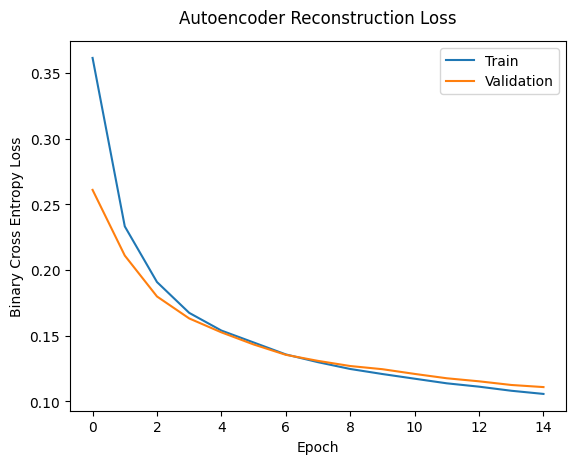

In [14]:
import matplotlib.pyplot as plt
plt.plot(history.history['loss'], label='Train')
plt.plot(history.history['val_loss'], label='Validation')
plt.ylabel('Binary Cross Entropy Loss')
plt.xlabel('Epoch')
plt.title('Autoencoder Reconstruction Loss', pad=13)
plt.legend(loc='upper right')

The loss on both training and validation is gradually decresing which is great

### Test the model on the original test set

313/313 [==============================] - 2s 5ms/step


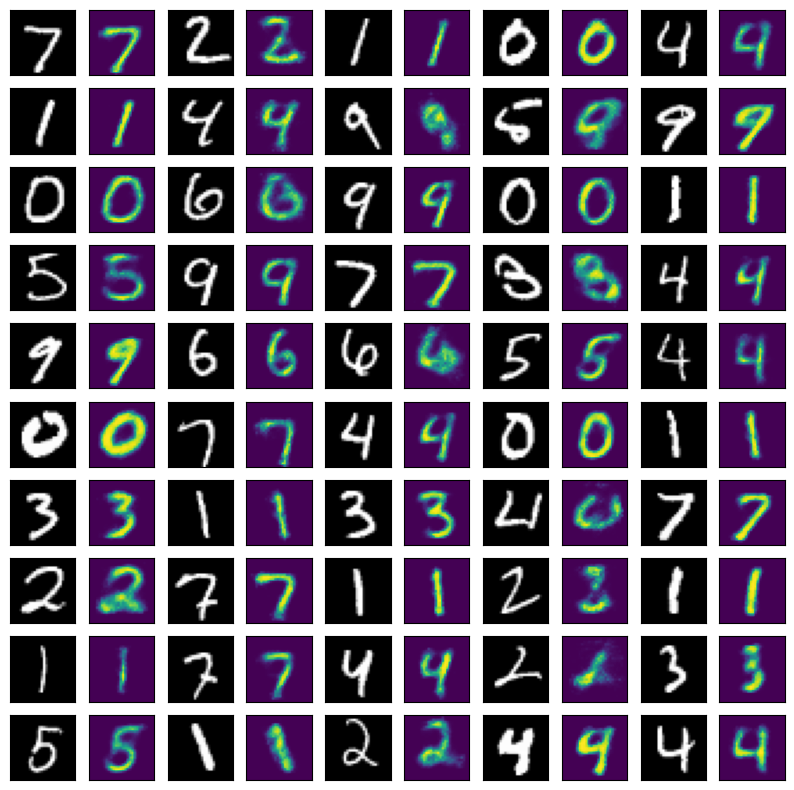

In [15]:
reconstructed_images = autoencoder.predict(test_images)

images = []
for i in range(100):
    images.append(test_images[i].reshape(28,28))
    images.append(reconstructed_images[i].reshape(28,28))
rows = 10
cols = 10
plt.figure(figsize=(10,10))
for i in range(rows*cols):
    plt.subplot(rows,cols,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    if (i%2 == 0):
        plt.imshow(images[i],cmap='gray')
    else:
        plt.imshow(images[i])
plt.show()

the model did not forget the previously trained digits

### Test the model on the new test set

1/1 [==============================] - 0s 53ms/step
(1, 784)


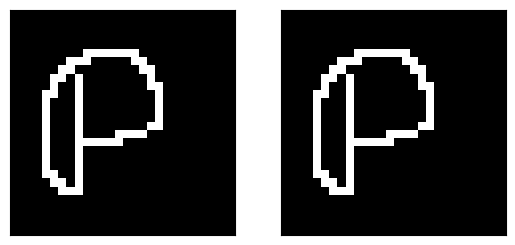

In [16]:
predictions = autoencoder.predict(firstchar_input_arr)
print(predictions.shape)


#####################################
# display the two images side by side
#
plt.subplot(1,2,1)
plt.xticks([])
plt.yticks([])
plt.grid(False)
plt.imshow(firstchar_image, cmap="gray")


plt.subplot(1,2,2)
plt.xticks([])
plt.yticks([])
plt.grid(False)
plt.imshow(predictions[0].reshape(28,28), cmap="gray")


plt.show()

1/1 [==============================] - 0s 73ms/step
(1, 784)


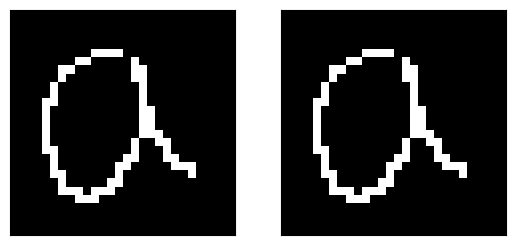

In [17]:

new_predictions = autoencoder.predict(lastchar_input_arr)
print(new_predictions.shape)


#####################################
# display the two images side by side
#
plt.subplot(1,2,1)
plt.xticks([])
plt.yticks([])
plt.grid(False)
plt.imshow(lastchar_image, cmap="gray")


plt.subplot(1,2,2)
plt.xticks([])
plt.yticks([])
plt.grid(False)
plt.imshow(new_predictions[0].reshape(28,28), cmap="gray")


plt.show()


35/35 [==============================] - 0s 8ms/step


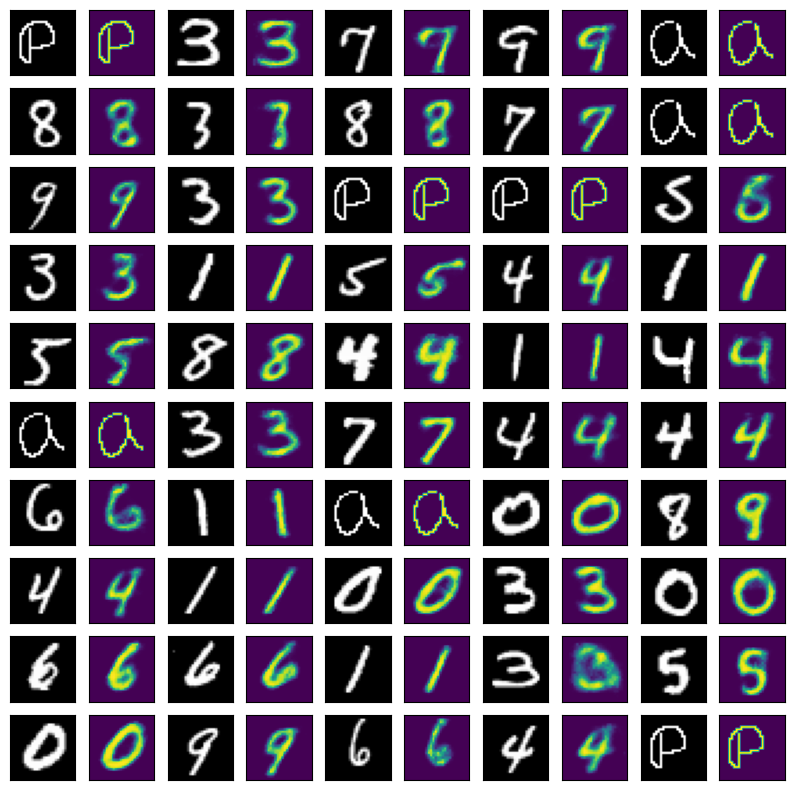

In [18]:
new_model = autoencoder.predict(new_images_test)

images = []
for i in range(100):
    images.append(new_images_test[i].reshape(28,28))
    images.append(new_model[i].reshape(28,28))
rows = 10
cols = 10
plt.figure(figsize=(10,10))
for i in range(rows*cols):
    plt.subplot(rows,cols,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    if (i%2 == 0):
        plt.imshow(images[i],cmap='gray')
    else:
        plt.imshow(images[i])
plt.show()

### Summary

In conclusion the model which was noyt trained initially did bad on prdicting my first and last characters of my last name but as I mixed the characters with the original trained 10 digits and randomly shuffeled the data set the model did not forget the orginal trained digits and it gave me my first and last characters of my last name correctly.